In [47]:
import numpy as np
import astropy.units as u
from astropy.io import fits

from gmagaox import utils
from gmagaox.imshows import *

import poppy

wavelength = 633*u.nm

In [48]:
dm2k_fpath = 'gmagaox/data/magaox_2K_best_full_flat_zygo.fits'
data = fits.getdata(dm2k_fpath)
n = data.shape[0]
data[247:297, 480:530] = data[311:361, 480:530]
surf_info = fits.getheader(dm2k_fpath)
display(surf_info)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  628                                                  
NAXIS2  =                  628                                                  
EXTEND  =                    T                                                  

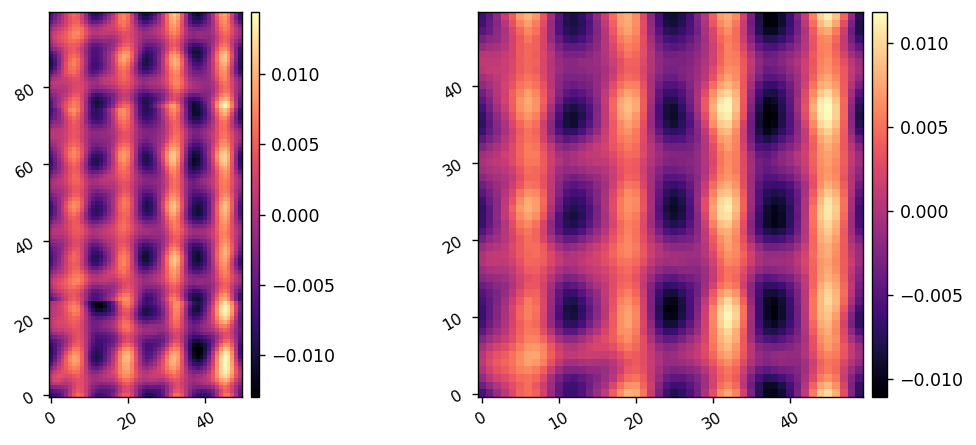

In [49]:
imshow2(data[222:322, 480:530], data[311:361, 480:530])

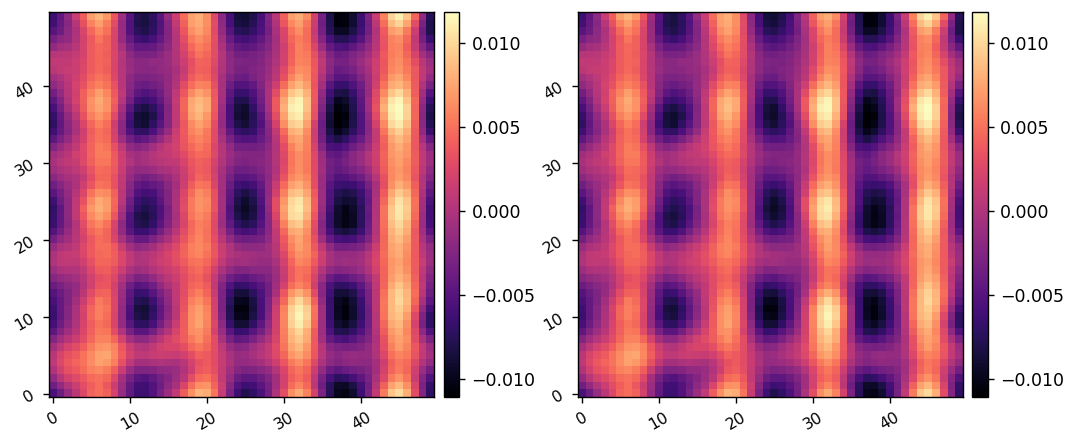

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
imshow2(data[247:297, 480:530], data[311:361, 480:530])
data

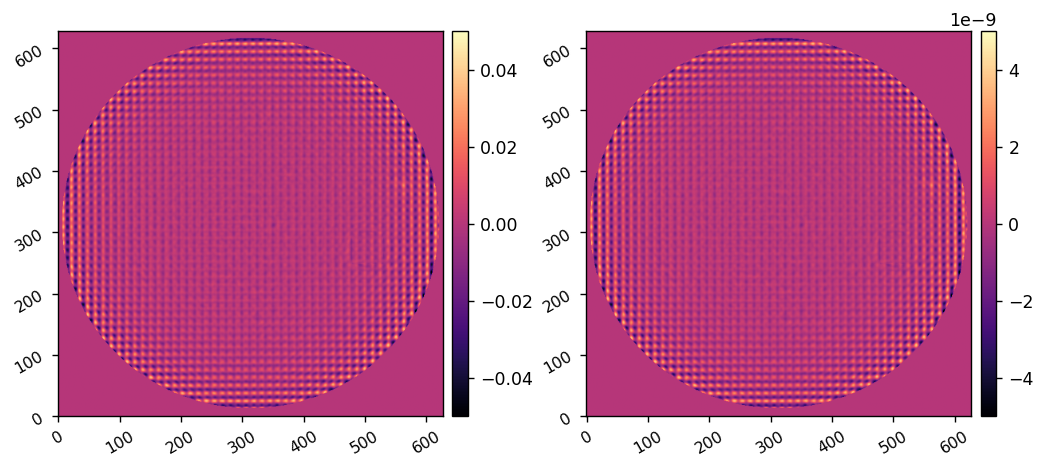

In [51]:

surf = data * wavelength.to_value(u.m)/(2*np.pi)

imshow2(data, surf, vmin1=-0.05, vmax1=0.05, vmin2=-5e-9, vmax2=5e-9)

<Quantity 25.21172854 mm / pix>

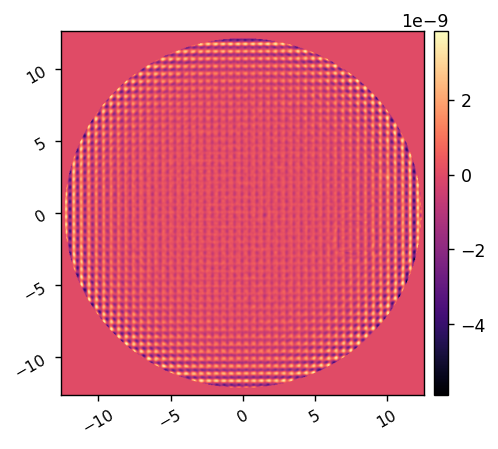

Saved data to:  gmagaox/data/ncp_opd.fits


In [52]:
ncp_pupil_diam = 23.9511421127869*u.mm
pxscl = ncp_pupil_diam/0.95 / (n*u.pix)
diam = n*pxscl
display(diam)
ncp_opd = surf
imshow1(surf, pxscl=pxscl)
utils.save_fits('gmagaox/data/ncp_opd.fits', ncp_opd, header={'PIXELSCL':pxscl.to_value(u.m/u.pix)})

<Quantity 72.88629845 mm / pix>

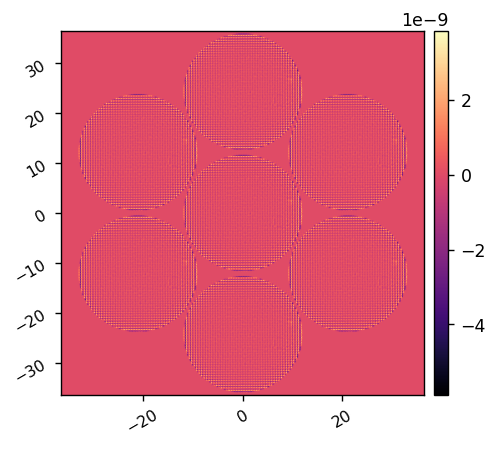

Saved data to:  gmagaox/data/tweeter_opd.fits


In [70]:
nt = int(3*n)
tweeter_opd = np.zeros((nt, nt))

# center coordinates
ccs = [
    (nt//2,nt//2), 
    (n//2,nt//2),
    (n, nt//2-int(n*np.sin(60*u.degree))),
    (2*n, nt//2-int(n*np.sin(60*u.degree))),
    (nt-n//2,nt//2), 
    (nt-n,nt//2+int(n*np.sin(60*u.degree))), 
    (n,nt//2+int(n*np.sin(60*u.degree))), 
] 

tweeter_opd = 0.0
for i in range(len(ccs)):
    arr = np.zeros((nt,nt))
    arr[ccs[i][0]-n//2:ccs[i][0]+n//2, ccs[i][1]-n//2:ccs[i][1]+n//2,] = surf
    tweeter_opd += arr

tweeter_pupil_diam = 72.8862984526303*u.mm
pxscl = tweeter_pupil_diam / (nt*u.pix)

diam = nt*pxscl
display(diam)
imshow1(tweeter_opd, pxscl=pxscl)

utils.save_fits('gmagaox/data/tweeter_opd.fits', tweeter_opd, header={'PIXELSCL':pxscl.to_value(u.m/u.pix)})


# Test operation with POPPY wavefront


In [71]:
ncp_pupil_diam = 23.9511421127869*u.mm

ncpDM_surf_fpath = 'gmagaox/data/ncp_opd.fits'
ncp_surf = poppy.FITSOpticalElement(opd=ncpDM_surf_fpath, opdunits='meters',
                                                   planetype=poppy.poppy_core.PlaneType.pupil,
                                                   name='NCP DM Surface')

wf = poppy.FresnelWavefront(beam_radius=ncp_pupil_diam/2, npix=2540, oversample=4096/2540, wavelength=wavelength)
wf *= ncp_surf


Oversampling > 2x suggested for reliable results in Fresnel propagation.


After resampling, optic phasor shape (2674, 2674) is smaller than input wavefront (4096, 4096); will zero-pad the rescaled array.


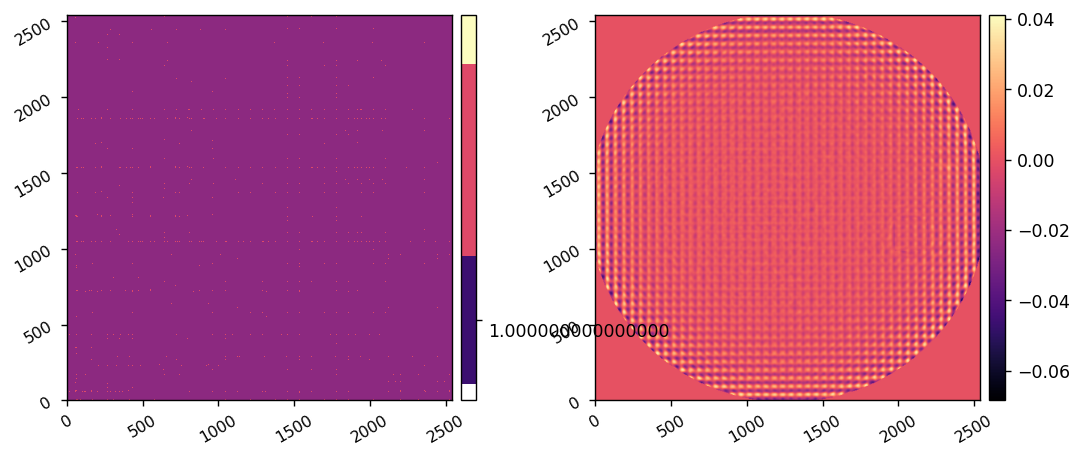

In [72]:
imshow2(wf.amplitude, wf.phase, npix=2540)

In [73]:
tweeter_pupil_diam = 72.8862984526303*u.mm

tweeter_surf_fpath = 'gmagaox/data/tweeter_opd.fits'
tweeter_surf = poppy.FITSOpticalElement(opd=tweeter_surf_fpath, opdunits='meters',
                                        planetype=poppy.poppy_core.PlaneType.pupil,
                                        name='Tweeter Surface')

wf = poppy.FresnelWavefront(beam_radius=tweeter_pupil_diam/2, npix=2540, oversample=4096/2540, wavelength=wavelength)
wf *= tweeter_surf

Oversampling > 2x suggested for reliable results in Fresnel propagation.
After resampling, optic phasor shape (2540, 2540) is smaller than input wavefront (4096, 4096); will zero-pad the rescaled array.


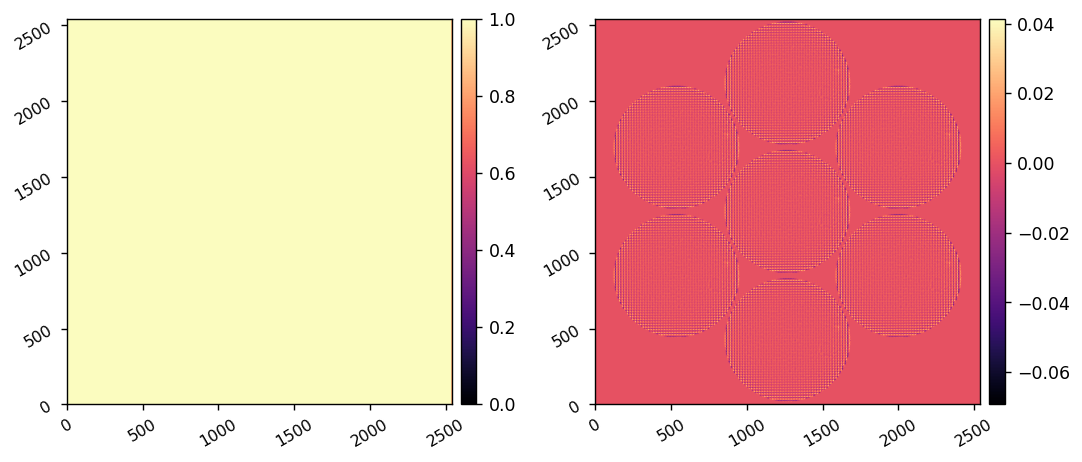

In [74]:
imshow2(wf.amplitude, wf.phase, npix=2540)

In [6]:
n

628

In [5]:
int(n*np.sin(30*u.degree))

313

In [ ]:
ncp_pupil_diam = 23.9511421127869*u.mm # acquired from Fresnel propagation
ncp_opd = surf

utils.save_fits('ncp_opds.fits', ncp_opd, header={'PIXELSCL':pxscl.to_value(u.m/u.pix)})